# BentoML Example: PyTorch Fashion MNIST Classification


[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. In this project we will use BentoML to package the image classifier model, and build a containerized REST API model server.

This notebook demonstrates how to use BentoML to turn a PyTorch model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

This example was built based on https://github.com/baldassarreFe/zalando-pytorch/blob/master/notebooks/4.0-fb-autoencoder.ipynb, if you are familiar with this, jump start to [Model Serving using BentoML](#Define-ML-service-with-BentoML)

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=pytorch&ea=pytorch-fashion-mnist&dt=pytorch-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install torch torchvision sklearn pillow pandas numpy

In [2]:
import bentoml
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.autograd import Variable

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

## Prepare Dataset

PyTorch supports FashionMNIST now, so we can import it directly.

In [3]:
from torchvision.datasets import FashionMNIST
FashionMNIST.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Load train and test set in batches of 1000.

The `28x28` images are scaled up to `29x29` so that combining convolutions and transposed convolutions would not chop off pixels from the reconstructed images.

In [4]:
batch_size = 1000

train_dataset = FashionMNIST(
    '../data', train=True, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(
    '../data', train=False, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Unsupervised reconstruction
Note that in this section we'll never use the image labels, the whole training is unsupervised.

### Autoencoder
The two components of the autoencoder are defined subclassing `nn.Module`, that gives more flexibility than `nn.Sequential`.

#### Encoder
A series of convolutions with `kernel_size=5` and `stride=2` is used to squeeze the images into a volume of 40x1x1, then a fully connected layer turns this vector in a vector of size `embedding_size`, that can be specified externally.

#### Decoder
The decoder takes up from where the encoder left, first transforming back the embedding of size `embedding_size` into a volume of size 40x1x1, then applying a series of Transposed Convolutions to yield an image of the same size of the original input.

At this time we can show some images in this Dataloader.

In [5]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, stride=2)
        self.fully = nn.Linear(40, embedding_size)

    def forward(self, x):
        # 1x29x29
        x = torch.relu(self.conv1(x))
        # 10x13x13
        x = torch.relu(self.conv2(x))
        # 20x5x5
        x = torch.relu(self.conv3(x))
        # 40x1x1
        x = x.view(x.data.shape[0], 40)
        # 40
        x = self.fully(x)
        # output_size
        return x

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.fully = nn.Linear(input_size, 40)
        self.conv1 = nn.ConvTranspose2d(40, 20, kernel_size=5, stride=2)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=5, stride=2)
        self.conv3 = nn.ConvTranspose2d(10, 1, kernel_size=5, stride=2)
    
    def forward(self, x):
        x = self.fully(x)
        x = x.view(x.data.shape[0], 40, 1, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

We are going to use an embedding size of 20, this number has no particular reason, except that it is in the same range of the number of classes. Naively, the network could learn to encode coarse-grained information (i.e. the kind of dress) in half of the embedding vector and then use the other half for fine-grained information.

In [6]:
embedding_size = 20
encoder = Encoder(embedding_size)
decoder = Decoder(embedding_size)

autoencoder = nn.Sequential(encoder, decoder)

#### Sanity check
A 29x29 black and white image passed through the autoencoder should give the same output dimension

In [7]:
x = Variable(torch.ones(1, 1, 29, 29))
e = encoder(x)
d = decoder(e)

print('Input\t ', list(x.data.shape))
print('Embedding', list(e.data.shape))
print('Output\t ', list(d.data.shape))

Input	  [1, 1, 29, 29]
Embedding [1, 20]
Output	  [1, 1, 29, 29]


### Training

In [8]:
autoencoder.train()

loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())
epoch_loss = []

for epoch in range(15):
    batch_loss = []
    for batch_num, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    print('Epoch {}:\tloss {:.4f}'.format(epoch, epoch_loss[-1]))

Epoch 0:	loss 0.1243
Epoch 1:	loss 0.0749
Epoch 2:	loss 0.0489
Epoch 3:	loss 0.0344
Epoch 4:	loss 0.0286
Epoch 5:	loss 0.0264
Epoch 6:	loss 0.0250
Epoch 7:	loss 0.0238
Epoch 8:	loss 0.0229
Epoch 9:	loss 0.0222
Epoch 10:	loss 0.0215
Epoch 11:	loss 0.0209
Epoch 12:	loss 0.0205
Epoch 13:	loss 0.0201
Epoch 14:	loss 0.0198


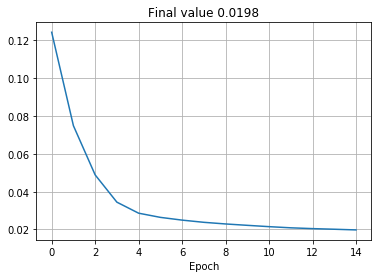

In [9]:
plt.plot(epoch_loss)
plt.title('Final value {:.4f}'.format(epoch_loss[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [10]:
autoencoder.eval()
data, targets = next(test_loader.__iter__())
encodings = encoder(Variable(data))
outputs = decoder(encodings)

print('Test loss: {:.4f}'.format(loss_fn(outputs, Variable(data)).item()))

Test loss: 0.0196


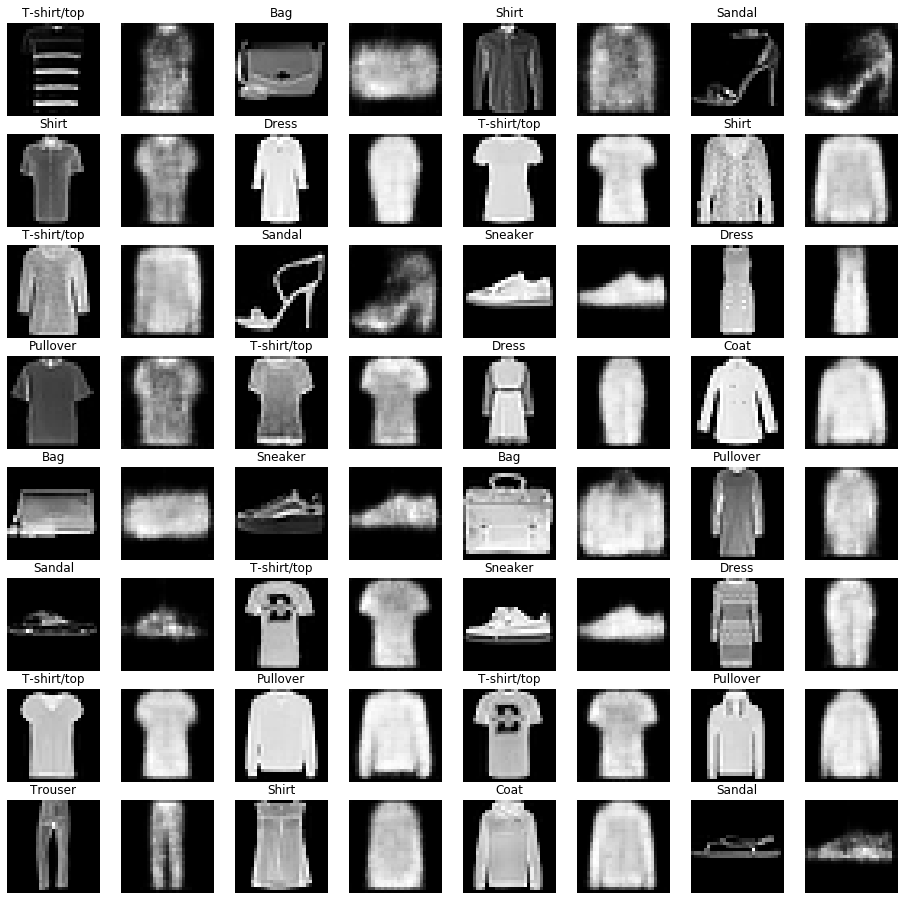

In [11]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.ravel()

zip_these = axes[::2], axes[1::2], data.numpy().squeeze(), outputs.data.numpy().squeeze(), targets
for ax1, ax2, original, reconstructed, target in zip(*zip_these):
    ax1.imshow(original, cmap='gray')
    ax1.axis('off')
    ax1.set_title(FashionMNIST.classes[target])
    ax2.imshow(reconstructed, cmap='gray')
    ax2.axis('off')

### Embeddings

The embeddings are 20-dimensional, t-SNE is used to visualize them as clusters in 2D space.

Even though the autoencoder learned the embeddings in a completely unsupervised way we can observe the emergence of clusters:
- __shoes__ (sandals, sneakers and ankle boot) are clustered together
- __bags__ form a group on their own (they are the only images with a clear squared-rectangular shape)
- same goes for __trousers__, that form their own group
- all the others are quite mixed together, meaning that the network has learned the concept of _clothes for the upper body_, but is not able to tell a __coat__ from a __pullover__

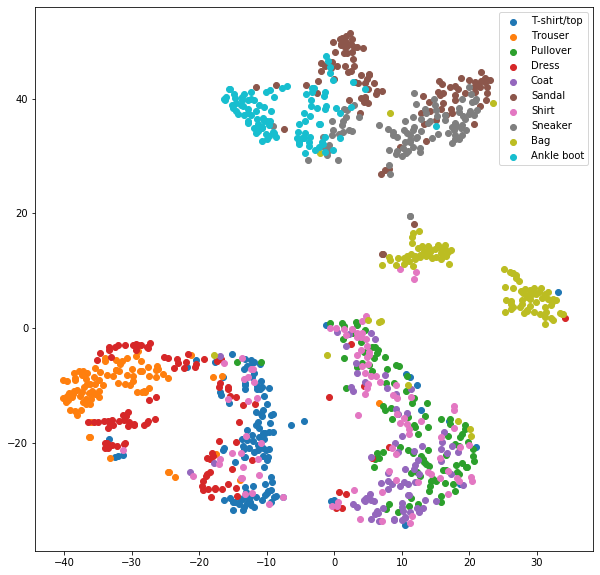

In [12]:
pca = TSNE(n_components=2)
encodings_2 = pca.fit_transform(encodings.data.numpy())
plt.figure(figsize=(10, 10))
for k in range(len(FashionMNIST.classes)):
    class_indexes = (targets.numpy() == k)
    plt.scatter(encodings_2[class_indexes, 0], encodings_2[class_indexes, 1], label=FashionMNIST.classes[k])
plt.legend();

## Supervised classification

Once trained in an unsupervised fashion, the encoder module can be used to generate _fashion_ embeddings (see what I did here?), that can then be used to train a simple classifier on the original labels.

### Model
The weights of the encoder are freezed, so only the classifier will be trained.

(later on, when the classifier starts performing decently, we could unfreeze them and do some fine-tuning)

In [13]:
for param in encoder.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    encoder, 
    nn.Linear(embedding_size, 15),
    nn.ReLU(),
    nn.Linear(15, len(FashionMNIST.classes)),
    nn.LogSoftmax()
)

### Training

In [14]:
classifier.train()

loss_fn = nn.NLLLoss()
optimizer = optim.Adam([p for p in classifier.parameters() if p.requires_grad])
epoch_loss = []

for epoch in range(15):
    batch_loss = []
    for batch_num, (data, targets) in enumerate(train_loader):
        data, targets = Variable(data), Variable(targets)
        optimizer.zero_grad()
        output = classifier(data)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    accuracy = accuracy_score(targets.data.numpy(), output.data.numpy().argmax(axis=1))
    print('Epoch {}:\tloss {:.4f}\taccuracy {:.2%}'.format(epoch, epoch_loss[-1], accuracy))

Epoch 0:	loss 2.9452	accuracy 42.70%
Epoch 1:	loss 1.2041	accuracy 64.70%
Epoch 2:	loss 0.9187	accuracy 68.10%
Epoch 3:	loss 0.8261	accuracy 70.00%
Epoch 4:	loss 0.7806	accuracy 73.40%
Epoch 5:	loss 0.7525	accuracy 72.00%
Epoch 6:	loss 0.7336	accuracy 72.90%
Epoch 7:	loss 0.7184	accuracy 71.70%
Epoch 8:	loss 0.7082	accuracy 75.30%
Epoch 9:	loss 0.6996	accuracy 71.30%
Epoch 10:	loss 0.6918	accuracy 73.40%
Epoch 11:	loss 0.6859	accuracy 74.40%
Epoch 12:	loss 0.6815	accuracy 73.50%
Epoch 13:	loss 0.6766	accuracy 74.00%
Epoch 14:	loss 0.6736	accuracy 76.30%


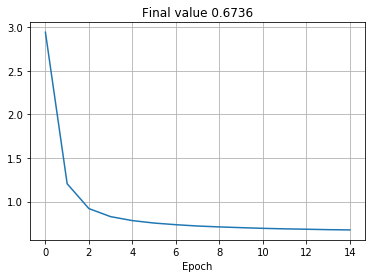

In [15]:
plt.plot(epoch_loss)
plt.title('Final value {:.4f}'.format(epoch_loss[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [16]:
classifier.eval()
data, targets = next(test_loader.__iter__())
outputs = classifier(Variable(data))
log_probs, output_classes = outputs.max(dim=1)

accuracy = accuracy_score(targets.numpy(), output_classes.data.numpy())
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 72.80%


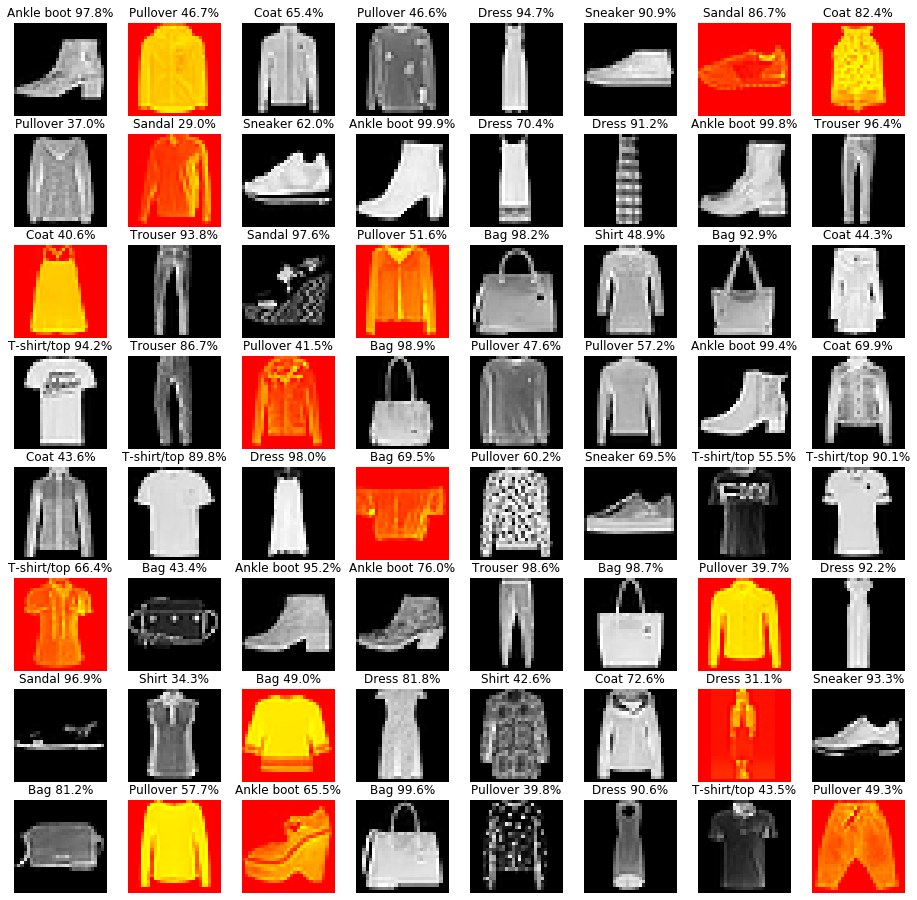

In [17]:
fig, axex = plt.subplots(8, 8, figsize=(16, 16))

zip_these = axex.ravel(), log_probs.data.exp(), output_classes.data, targets, data.numpy().squeeze()
for ax, prob, output_class, target, img in zip(*zip_these):
    ax.imshow(img, cmap='gray' if output_class == target else 'autumn')
    ax.axis('off')
    ax.set_title('{} {:.1%}'.format(FashionMNIST.classes[output_class], prob))

## Define BentoService for model serving

In [18]:
%%writefile pytorch_fashion_mnist.py

import bentoml
from PIL import Image
from torchvision import transforms

from bentoml.artifact import PytorchModelArtifact
from bentoml.handlers import ImageHandler


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('classifier')])
class FashionMNISTServicer(bentoml.BentoService):

    @bentoml.api(ImageHandler, pilmode='L')
    def predict(self, image):
        img = Image.fromarray(image).resize((28, 28))
        transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()])
        img_tensor = transform(img)
        outputs = self.artifacts.classifier(img_tensor.unsqueeze(0))        
        _, output_classes = outputs.max(dim=1)
        
        return FASHION_MNIST_CLASSES[output_classes]

Overwriting pytorch_fashion_mnist.py


## Save BentoService to file archive


In [19]:
# 1) import the custom BentoService defined above
from pytorch_fashion_mnist import FashionMNISTServicer

# 2) `pack` it with required artifacts
bento_svc = FashionMNISTServicer.pack(classifier=classifier)

# 3) save your BentoSerivce
saved_path = bento_svc.save()

[2019-09-19 12:20:55,162] INFO - Successfully saved Bento 'FashionMNISTServicer:2019_09_19_8a0375b7' to path: /Users/chaoyuyang/bentoml/repository/FashionMNISTServicer/2019_09_19_8a0375b7


## Model Serving via REST API

In your termnial, run the following command to start the REST API server:### Run REST API server

In [20]:
!bentoml serve {saved_path}

 * Serving Flask app "FashionMNISTServicer" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Sep/2019 12:52:50] "GET / HTTP/1.1" 200 -
/Users/chaoyuyang/anaconda3/envs/bentoml-dev/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
127.0.0.1 - - [19/Sep/2019 12:52:58] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [19/Sep/2019 12:53:01] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [19/Sep/2019 12:53:04] "POST /predict HTTP/1.1" 200 -
^C


### Call REST API from a client

Sending POST request from termnial:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

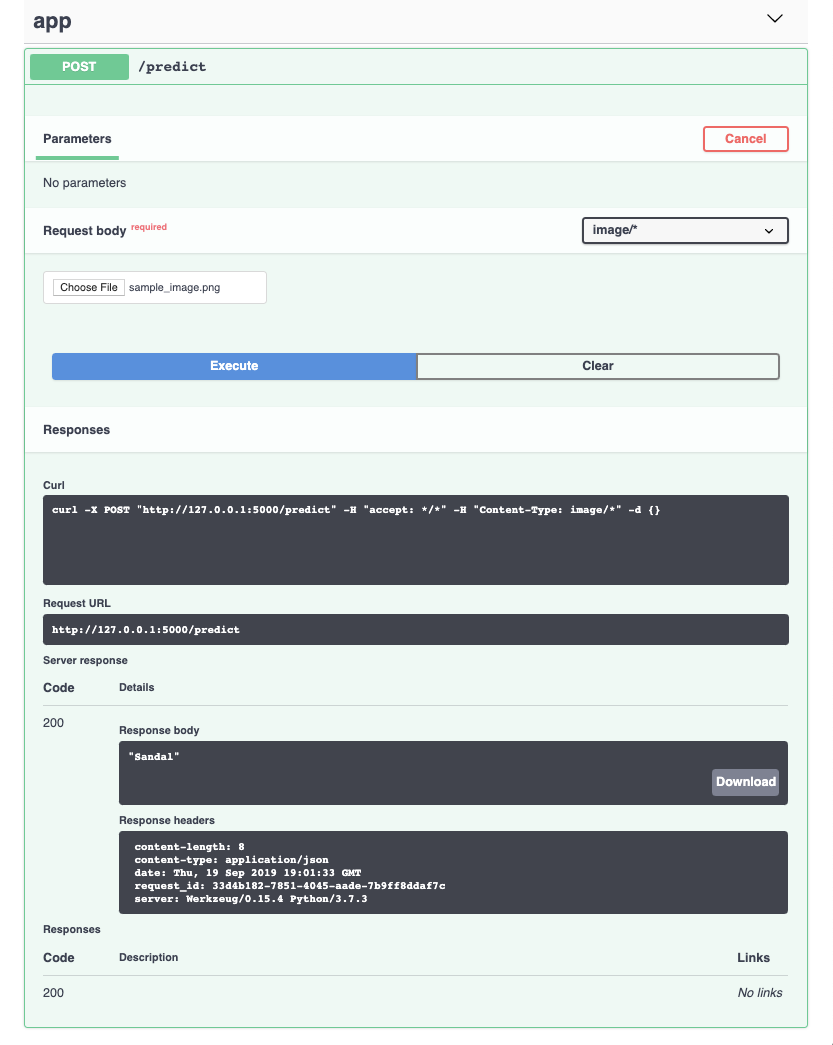

## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [21]:
!cd {saved_path} && docker build . -t pytorch-fashion-mnist

Sending build context to Docker daemon  133.6kB
Step 1/11 : FROM continuumio/miniconda3
 ---> ae46c364060f
Step 2/11 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 2f135ada8e2d
Step 3/11 : EXPOSE 5000
 ---> Using cache
 ---> 738f652d09ae
Step 4/11 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 70c62a45013a
Step 5/11 : RUN conda update conda -y       && conda install pip numpy scipy       && pip install gunicorn six
 ---> Using cache
 ---> fe5d966ecc35
Step 6/11 : COPY . /bento
 ---> d00c6768ebbe
Step 7/11 : WORKDIR /bento
 ---> Running in 65e4f1f8e11f
Removing intermediate container 65e4f1f8e11f
 ---> d0a6e7065765
Step 8/11 : RUN conda env update -n base -f /bento/environment.yml
 ---> Running in 6166f7e1de32
Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The followin

Removing intermediate container 6166f7e1de32
 ---> 666f7c81f870
Step 9/11 : RUN pip install -r /bento/requirements.txt
 ---> Running in 85f87d646259


Removing intermediate container 85f87d646259
 ---> b4f9c1c9445b
Step 10/11 : RUN if [ -f /bento/setup.sh ]; then /bin/bash -c /bento/setup.sh; fi
 ---> Running in 71825c516006
Removing intermediate container 71825c516006
 ---> bc37731d5d39
Step 11/11 : CMD ["bentoml serve-gunicorn /bento"]
 ---> Running in 4050988df254
Removing intermediate container 4050988df254
 ---> d6ed6efbdf93
Successfully built d6ed6efbdf93
Successfully tagged pytorch-fashion-mnist:latest


In [22]:
!docker run -p 5000:5000 pytorch-fashion-mnist

[2019-09-19 19:57:42 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2019-09-19 19:57:42 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2019-09-19 19:57:42 +0000] [1] [INFO] Using worker: sync
[2019-09-19 19:57:42 +0000] [10] [INFO] Booting worker with pid: 10
[2019-09-19 19:57:42 +0000] [11] [INFO] Booting worker with pid: 11
[2019-09-19 19:57:42 +0000] [12] [INFO] Booting worker with pid: 12
^C
[2019-09-19 20:04:03 +0000] [1] [INFO] Handling signal: int
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
[2019-09-19 20:04:03 +0000] [12] [INFO] Worker exiting (pid: 12)
[2019-09-19 20:04:03 +0000] [10] [INFO] Worker exiting (pid: 10)
[2019-09-19 20:04:03 +0000] [11] [INFO] Worker exiting (pid: 11)
